In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras.regularizers import l2
tf.keras.backend.set_floatx('float64')

In [22]:
# Setting up data
N = 6
Q = np.random.rand(N, N)
A = (Q.T + Q)/2 - np.eye(N)

# eigenvalues from max to min
eigenvalues, v = np.linalg.eig(A)
eig_vec_anal = v[:,0]
eig_val_anal = eigenvalues[0]
print(eig_val_anal)
print(eig_vec_anal)

2.0714271785626925
[-0.51000837 -0.43109618 -0.41641456 -0.37701696 -0.40738339 -0.26933892]


In [35]:
def loss(model, x0, t):
    with tf.GradientTape() as tape_t:
        tape_t.watch([t])
        x_net = tf.exp(-t) @ x0 + model(t) * (1-tf.exp(-t))
    dx_dt = tape_t.batch_jacobian(x_net, t)[:, :, 0] # This takes the gradient of each element of x for each time step
    
    dx_dt = tf.transpose(dx_dt) # We need to transpose, as x_net is a collection of row vectors,
    x_net = tf.transpose(x_net) # but we need a collection of column vectors for the matrix multiplications
    
    Ax = A @ x_net
    xTx = tf.einsum("ij,ji->i", tf.transpose(x_net), x_net)
    xTAx = tf.einsum("ij,ji->i", tf.transpose(x_net), Ax)
    fx = xTx * Ax + (1 - xTAx) * x_net
    
    return tf.losses.mean_squared_error(zeros, dx_dt - fx + x_net)

def train(model, optimizer, x0, t):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x0, t)

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

x0 = np.random.rand(N, 1) * 2 - 1
x0 /= np.linalg.norm(x0) # normalize
x0 = tf.reshape(tf.convert_to_tensor(x0, dtype=tf.dtypes.float64), shape=(1, -1)) # row vector, since the NN outputs row vectors

Nt = 50
T_n = 10
t = np.linspace(0, T_n, Nt)
t = tf.reshape(tf.convert_to_tensor(t, dtype=tf.dtypes.float64), shape=(-1, 1)) # column vector

zeros = tf.convert_to_tensor(np.zeros((N, Nt)))

# Setting up model
model = Sequential()
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(25, activation='sigmoid'))
model.add(Dense(N, activation="linear"))
model.build(t.shape)

eta = 0.01
sgd = optimizers.Adam(eta)
train(model, sgd, x0, t)
g_dnn = tf.transpose(tf.exp(-t) @ x0 + model(t) * (1-tf.exp(-t)))

In [37]:
iters = 100
for i in range(iters):
    train(model, sgd, x0, t)
    
# Output of model
g_dnn = tf.transpose(tf.exp(-t) @ x0 + model(t) * (1-tf.exp(-t)))

[0.5798521  0.49972177 0.38980593 0.14936122 0.38265445 0.3055615 ]
2.492 +- 1.428


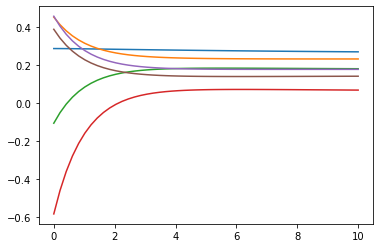

In [38]:
eig_vec = np.array(g_dnn[:, -1])
eig_vec /= np.linalg.norm(eig_vec)
print(eig_vec)
print(f"{np.mean(A @ eig_vec / eig_vec):.3f} +- {np.std(A @ eig_vec / eig_vec):.3f}")

for i in range(N):
    plt.plot(np.linspace(0, T_n, Nt), g_dnn[i, :])

In [31]:
# eigenvalues from max to min
eigenvalues, v = np.linalg.eig(A)
eig_vec_anal = v[:,0]
eig_val_anal = eigenvalues[0]
print(eig_vec_anal)
print(eig_val_anal)

[-0.51000837 -0.43109618 -0.41641456 -0.37701696 -0.40738339 -0.26933892]
2.0714271785626925


In [32]:
print(eigenvalues)
print(v)

[ 2.07142718 -0.32763347 -1.58426596 -1.27567691 -0.96607392 -0.83561776]
[[-0.51000837 -0.54930443 -0.1532937  -0.2838332  -0.57684937  0.03661519]
 [-0.43109618 -0.18053997  0.67583767  0.39070761  0.20414785  0.36121471]
 [-0.41641456  0.11898408  0.26180336 -0.37645083  0.32581291 -0.70429499]
 [-0.37701696  0.80631011  0.01491888 -0.02075567 -0.41661069  0.18304202]
 [-0.40738339 -0.01225455 -0.57119134  0.64647811  0.1908972  -0.23076692]
 [-0.26933892  0.03502264 -0.35315913 -0.45464965  0.55624473  0.53422287]]


In [33]:
# eigenvalues from max to min
eigenvalues, v = np.linalg.eig(-A)
eig_vec_anal = v[:,0]
eig_val_anal = eigenvalues[0]
print(eig_vec_anal)
print(eig_val_anal)

[0.51000837 0.43109618 0.41641456 0.37701696 0.40738339 0.26933892]
-2.0714271785626925


In [34]:
print(eigenvalues)
print(v)

[-2.07142718  0.32763347  1.58426596  1.27567691  0.96607392  0.83561776]
[[ 0.51000837  0.54930443 -0.1532937  -0.2838332  -0.57684937  0.03661519]
 [ 0.43109618  0.18053997  0.67583767  0.39070761  0.20414785  0.36121471]
 [ 0.41641456 -0.11898408  0.26180336 -0.37645083  0.32581291 -0.70429499]
 [ 0.37701696 -0.80631011  0.01491888 -0.02075567 -0.41661069  0.18304202]
 [ 0.40738339  0.01225455 -0.57119134  0.64647811  0.1908972  -0.23076692]
 [ 0.26933892 -0.03502264 -0.35315913 -0.45464965  0.55624473  0.53422287]]
